### Spawn other objects

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from mujoco_parser import MuJoCoParserClass
from util import rpy2r
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Parse `Panda` with objects

In [2]:
xml_path = '../model/panda/franka_panda_w_objs.xml'
env = MuJoCoParserClass(name='Panda',rel_xml_path=xml_path,VERBOSE=False)
env.reset() # reset
print ("[Panda] parsed.")

[Panda] parsed.


### Set objects

In [3]:
obj_names = env.get_body_names(prefix='obj_')
n_obj = len(obj_names)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
colors[:,3] = 1.0
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos = [-1.0,0.1*obj_idx,0.01]
    obj_quat = [0,0,0,1]
    env.model.body(obj_name).ipos = obj_pos
    env.model.body(obj_name).iquat = obj_quat
    env.model.geom(obj_name).rgba = colors[obj_idx] # color
# Change table color
table_color = [0.65,0.64,0.68]
env.model.geom('panda_pedestal').rgba[:3] = table_color
env.model.geom('work_space').rgba[:3] = table_color
# Add transparency to geoms
for geom_name in env.geom_names:
    if geom_name == 'ground': continue
    env.model.geom(geom_name).rgba[3] = 0.8
env.forward()
print ("Done.")

Done.


In [4]:
# Place objects on the table
n_place = 5
obj2place_names = [obj_names[o_idx] for o_idx in np.random.permutation(n_obj)[:n_place].astype(int)]

x_range = [0.3,1.0]
y_range = [-0.5,0.5]
z_range = [1.01,1.01]
min_dist_btw_obj = 0.15 # minimum distance between objects
obj2place_poses  = np.zeros((n_place,3))
for o_idx in range(n_place):
    loop_cnt = 0
    while True:
        loop_cnt = loop_cnt + 1
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),obj2place_poses[:o_idx,:].reshape((-1,3)),'euclidean')
            if devc.min() > min_dist_btw_obj: break # minimum distance between objects
        else:
            break
    obj2place_poses[o_idx,:] = xyz
for obj_idx,obj_name in enumerate(obj2place_names):
    env.model.body(obj_name).ipos = obj2place_poses[obj_idx]
print ("Done.")

Done.


### Render

In [5]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.update_viewer(VIS_CONTACTPOINT=True,contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.reset() # reset
# Loop
imgs,img_ticks,max_tick = [],[],500
while (env.tick < max_tick) and env.is_viewer_alive():
    # Step 
    env.step(nstep=5)
    # Render
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0,axis_width=0.01)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
# Close viewer
env.close_viewer()
print ("Done.")    

Pressed ESC
Quitting.
Done.


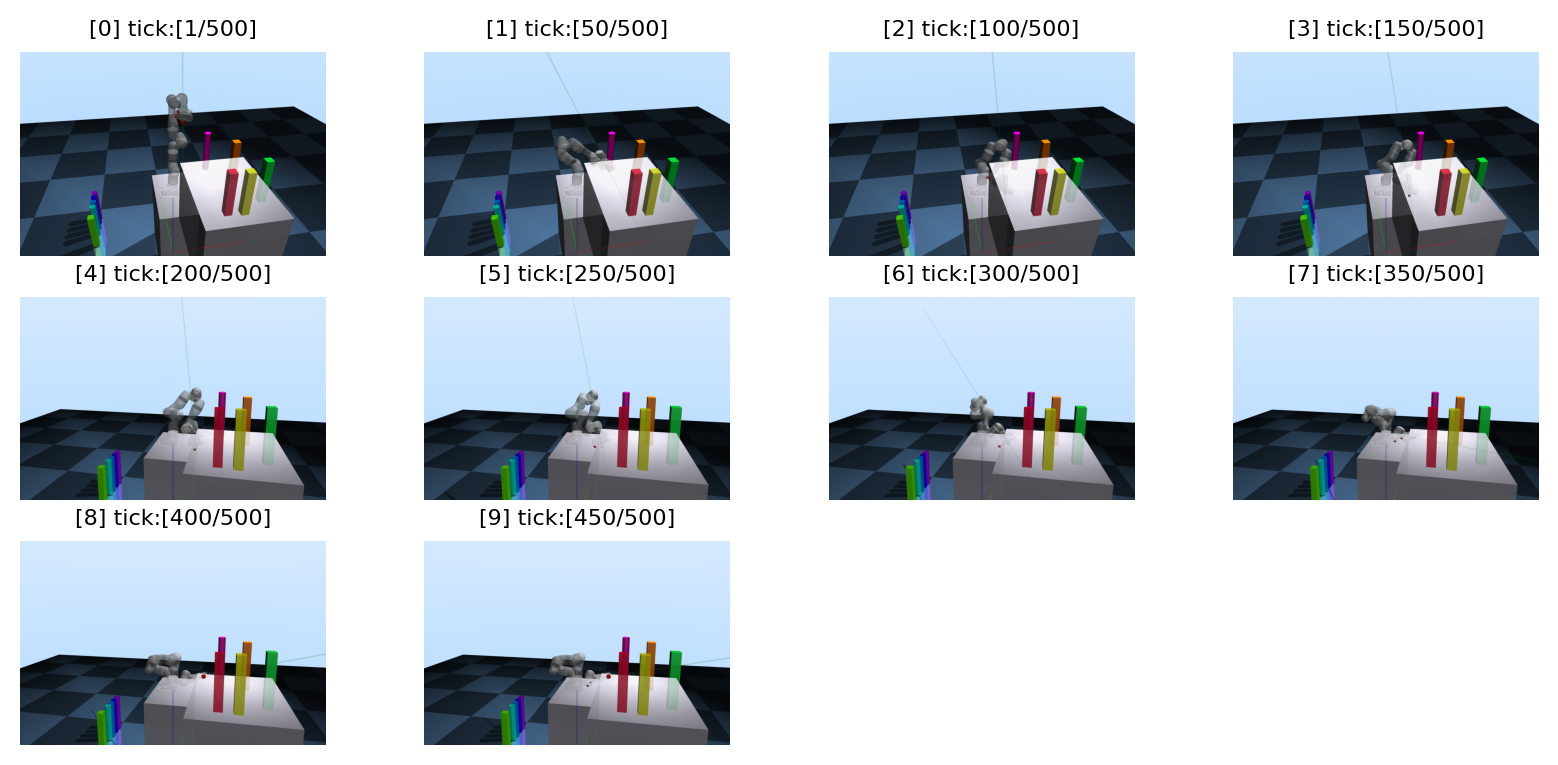

In [6]:
# Plot snapshots for Panda solving IK
n_row = np.ceil(len(imgs)/4).astype(np.int32)
fig = plt.figure(figsize=(10,1.5*n_row))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(np.ceil(len(imgs)/4).astype(np.int32),4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d/%d]'%(i_idx,img_ticks[i_idx],max_tick),fontsize=8)
    ax.axis('off')